In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.models import Model

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Ari
[nltk_data]     Widyatama\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
path ='medical-related.json'
with open(path) as file:
    data = json.load(file)

In [27]:
patterns = []
tags = []
responses = {}

for intent in data['intents']:
    for pattern in intent['patterns']:
        patterns.append(pattern)
        tags.append(intent['tag'])
    responses[intent['tag']] = intent['responses']

print(len(patterns))
print(len(responses))
print(len(tags))
print(patterns[0:9])
print(tags[0:9])

246
55
246
['What to do if Cuts?', 'How to cure Cuts?', 'Which medicine to apply for Cuts?', 'what to apply on cuts?', 'Cuts', 'how do you treat abrasions?', 'Do Abrasions cause scars?', 'Abrasions', 'what to do if abrasions?']
['Cuts', 'Cuts', 'Cuts', 'Cuts', 'Cuts', 'Abrasions', 'Abrasions', 'Abrasions', 'Abrasions']


In [28]:
def splitDataset(inputs, labels):
    totalData = len(inputs)
    valSize = int(totalData * 0.2)
    valSplit = list(range(0, valSize * 5, 5))
    trainSplit = [i for i in range(totalData) if i not in valSplit]


    trainTexts = [inputs[i] for i in trainSplit]
    valTexts = [inputs[i] for i in valSplit]
    trainLabels = [labels[i] for i in trainSplit]
    valLabels = [labels[i] for i in valSplit]

    trainDataset = tf.data.Dataset.from_tensor_slices((trainTexts, trainLabels))
    valDataset = tf.data.Dataset.from_tensor_slices((valTexts, valLabels))

    return trainDataset, valDataset

In [29]:
trainDataset, valDataset = splitDataset(patterns, tags)

print(f"There are {trainDataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {valDataset.cardinality()} sentence-label pairs for validation.\n")

print(trainDataset)
print(valDataset)

There are 197 sentence-label pairs for training.

There are 49 sentence-label pairs for validation.

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>
<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>


In [30]:
for data in trainDataset.take(10).as_numpy_iterator():
    print(data)

for data in valDataset.take(10).as_numpy_iterator():
    print(data)

(b'How to cure Cuts?', b'Cuts')
(b'Which medicine to apply for Cuts?', b'Cuts')
(b'what to apply on cuts?', b'Cuts')
(b'Cuts', b'Cuts')
(b'Do Abrasions cause scars?', b'Abrasions')
(b'Abrasions', b'Abrasions')
(b'what to do if abrasions?', b'Abrasions')
(b'Which medicine to apply for abrasions?', b'Abrasions')
(b'How do you treat Sting?', b'stings')
(b'Stings', b'stings')
(b'What to do if Cuts?', b'Cuts')
(b'how do you treat abrasions?', b'Abrasions')
(b'How to cure abrasions?', b'Abrasions')
(b'How to remove Splinters', b'Splinter')
(b'what to do if i get a sprain?', b'Sprains')
(b'Which cream to apply if i get a strain?', b'Strains')
(b'what to do if i get a mild fever?', b'Fever')
(b'Which medicine to take if I have a nasal congestion?', b'Nasal Congestion')
(b'How do you treat cough?', b'Cough')
(b'what to do if i get a sore throat?', b'Sore Throat')


In [31]:
stopWords = stopwords.words('english')
print(stopWords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [32]:
def standardizeFunc(sentence):
    stopwords = stopWords
    sentence = tf.strings.lower(sentence)

    for word in stopwords:
        if word[0] == "'":
            sentence = tf.strings.regex_replace(sentence, rf"{word}\b", "")
        else:
            sentence = tf.strings.regex_replace(sentence, rf"\b{word}\b", "")
    sentence = tf.strings.regex_replace(sentence, r'[!"#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', "")

    return sentence

In [33]:
maxLeght = 30
def fitVectorizer(trainSentences, standardizeFunc):
    vectorizer = tf.keras.layers.TextVectorization(
		standardize=standardizeFunc,
    output_sequence_length=maxLeght
	)
    vectorizer.adapt(trainSentences)
    return vectorizer

In [34]:
textDataset = trainDataset.map(lambda text, label: text)
vectorizer = fitVectorizer(textDataset, standardizeFunc)
vocabSize = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocabSize} words\n")

Vocabulary contains 128 words



In [35]:
def fitLabelEncoder(trainLabel, valLabel):
    trainLabel = list(trainLabel.as_numpy_iterator())
    valLabel = list(valLabel.as_numpy_iterator())
    labels = trainLabel + valLabel

    labelEncoder = tf.keras.layers.StringLookup(num_oov_indices=0)
    labelEncoder.adapt(labels)

    return labelEncoder

In [36]:
trainLabels = trainDataset.map(lambda text, label: label)
valLabels = valDataset.map(lambda text, label: label)

labelEncoder = fitLabelEncoder(trainLabels,valLabels)
uniqLabel = len(labelEncoder.get_vocabulary())

print(f'Unique labels: {labelEncoder.get_vocabulary()}')
print(f'Number of unique labels: {uniqLabel}')

Unique labels: ['animal bite', 'Strains', 'Nasal Congestion', 'Itching', 'Eye Pain', 'Burns', 'Abrasions', 'snake bite', 'Sunburn', 'Nosebleeds', 'Itchy Eyes', 'Hypothermia', 'Frostbite', 'Food Poisoning', 'Cuts', 'Cough', 'Blisters', 'Allergic Reactions', 'stings', 'seizure', 'nose bleed', 'Wound', 'Vertigo', 'Testicle Pain', 'Teeth', 'Sun Burn', 'Sprains', 'Splinter', 'Sore Throat', 'Skin problems', 'Rectal bleeding', 'Rash', 'Pulled Muscle', 'Poison', 'Normal Bleeding', 'Insect Bites', 'Heat Stroke', 'Heat Exhaustion', 'Headache', 'Head Injury', 'Gastrointestinal problems', 'Frost bite', 'Fracture', 'Fever', 'Fainting', 'Eye Injury', 'Drowning', 'Diarrhea', 'Cold', 'Choking', 'Chemical Burn', 'CPR', 'Bruises', 'Broken Toe', 'Abdonominal Pain']
Number of unique labels: 55


In [37]:
def preprocessDataset(dataset, textVectorizer, labelEncoder):
    dataset = dataset.map(lambda text, label: (textVectorizer(text), labelEncoder(label)))
    dataset = dataset.batch(8)

    return dataset

In [38]:
trainProcDataset = preprocessDataset(trainDataset, vectorizer, labelEncoder)
valProcDataset = preprocessDataset(valDataset, vectorizer, labelEncoder)

print(f"Number of batches in the train dataset: {trainProcDataset.cardinality()}")
print(f"Number of batches in the validation dataset: {valProcDataset.cardinality()}")

trainBatch = next(trainProcDataset.as_numpy_iterator())
valBatch = next(valProcDataset.as_numpy_iterator())

print(f"Shape of the train batch: {trainBatch[0].shape}")
print(f"Shape of the validation batch: {valBatch[0].shape}")

Number of batches in the train dataset: 25
Number of batches in the validation dataset: 7
Shape of the train batch: (8, 30)
Shape of the validation batch: (8, 30)


In [39]:
for text, label in trainProcDataset.take(5):
    print("Sample text:", text.numpy())
    print("Sample label:", label.numpy())

for text, label in valProcDataset.take(5):
    print("Sample text:", text.numpy())
    print("Sample label:", label.numpy())

Sample text: [[  6  37   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  4   9  37   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  9  37   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [ 37   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [ 42 118  97   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [ 42   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [ 42   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  4   9  42   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 

In [79]:
def create_model():
    inputLayer = tf.keras.Input(shape=(None,))

    embedLayer = tf.keras.layers.Embedding(input_dim=vocabSize, output_dim=64)(inputLayer)
    bilLSTM1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False))(embedLayer)
    dense1 = tf.keras.layers.Dense(32, activation='relu')(bilLSTM1)
    dropout1 = tf.keras.layers.Dropout(0.3)(dense1)
    outputLayer = tf.keras.layers.Dense(uniqLabel, activation='softmax')(dropout1)
    
    model = Model(inputs=inputLayer, outputs=outputLayer)

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

In [82]:
modelPhychan = create_model()
modelPhychan.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_13 (Embedding)        │ (None, None, 64)       │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 128)            │        66,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 55)             │         1,815 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,183 (313.21 KB)

 Trainable params: 80,183 (313.21 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc >= 0.9 and val_acc >= 0.9:
            self.model.stop_training = True


In [84]:
history = modelPhychan.fit(trainProcDataset, epochs=50, validation_data=valProcDataset, callbacks=myCallback())

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.0113 - loss: 4.0141 - val_accuracy: 0.0204 - val_loss: 4.0077
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0567 - loss: 3.9965 - val_accuracy: 0.0204 - val_loss: 4.0056
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0340 - loss: 3.9992 - val_accuracy: 0.0204 - val_loss: 4.0022
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0575 - loss: 3.9975 - val_accuracy: 0.0204 - val_loss: 3.9993
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0714 - loss: 3.9873 - val_accuracy: 0.0204 - val_loss: 3.9918
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0664 - loss: 3.9795 - val_accuracy: 0.0204 - val_loss: 3.9803
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0718 - loss: 3.9501 - val_accuracy: 0.0204 - val_loss: 3.9524
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0649 - loss: 3.9611 - val_accuracy: 0.0816 - v

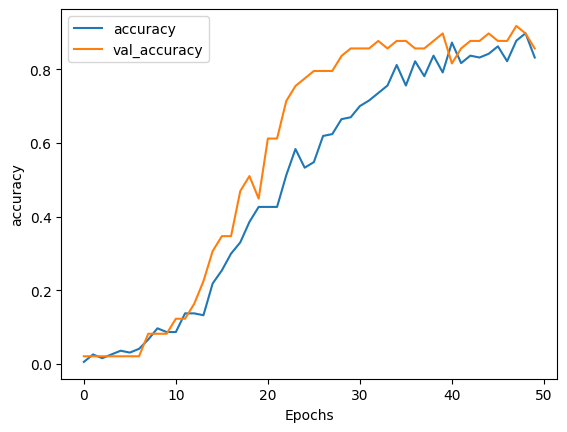

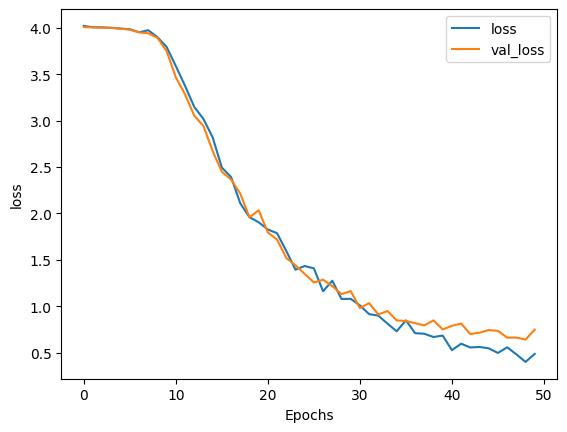

In [85]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [86]:
def getResponse(predictTag, responses, confidence):
    if confidence < 0.4:
        return "Maaf, input yang Anda masukkan kurang jelas."
    return np.random.choice(responses[predictTag])

In [87]:
def showRespon(input):
    inputA = vectorizer([input])
    prediction = modelPhychan.predict(inputA)

    predictClassIndex = np.argmax(prediction, axis=-1)
    confidence = prediction[0][predictClassIndex[0]]
    predictTag = labelEncoder.get_vocabulary()[predictClassIndex[0]]
    response = getResponse(predictTag, responses, confidence)

    return predictTag, response, confidence


In [88]:
testInput = "sore throat?"

predictTag, response, confidence = showRespon(testInput)

print(f"Predicted tag: {predictTag}")
print(f"Confidence: {confidence:.2f}")
print(f"Response: {response}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
Predicted tag: Sore Throat
Confidence: 0.95
Response: 1) Make sure you get plenty of rest and drink a lot of fluids. 2)Inhale steam,Run hot water in a sink.Drape a towel over you to trap the steam, and have the person lean over the sink with the water running. Tell him to breathe deeply through his mouth and nose for 5 to 10 minutes. Repeat several times a day. 3)Have him sip chicken broth or warm tea with honey. Donâ€™t give honey to a child under 12 months of age.
